#### Introduction
The prefferred models (from the hyperparameter vs performance metric visuals) are 
analysed by assessing the distribution of the model residuals. 

#### Aim
To identify the optimal model for predicting baseline indices in site/species groups with
12-14 observations.

#### Workflow
1) The predicted baseline indices are acquired. The predictions to be analysed first 
relate to the prefferred model identified in the hyperparameter vs performance 
metric visualisations (lambda=0.6, spline count=4).
2) The actual baseline indices are acquired and log transformed (the predictions are already
in log form). These are stored in the same dataframe as the predictions.
3) The residuals are computed.
4) The predictions and residuals are visualised:
    - Predicted vs Actual Abundance Visual
    - Fitted Values vs Residuals Visual
    - Q-Q Plot of abundance residuals
5) For comparison, baseline predictions corresponding to another model (lambda=-1.8,
spline count=9) are acquired. Note that this model generated a higher error, but also had
the greatest correlation coefficient.
7) Residuals relating to the model 'lambda=-1.8, spline count=9' are computed.
8) The predictions and residuals relating to both models are plotted together for comparison:
    - Predicted vs Actual Abundance Visual
    - Fitted Values vs Residuals Visual
    - Q-Q Plot of abundance residuals

#### Note
For improved readability, lambda values are log10 base. Hence lambda=-1.8 represents lambda=10^-1.8 
and lambda=0.6 represents lambda=10^0.6

In [1]:
# Importing packages
import pandas as pd
import numpy as np
import pickle
import os
from pathlib import Path

# Importing localised file directory
project_root = Path(os.environ['butterfly_project'])

# Importing data
# Prediction data holds the baseline site index predictions from the site/species level
# GAM
with open(project_root/'Data'/'UKBMS'/'gam_optimisation'/'obs_12_13_14'/'obs_12_13_14_parameters.pkl','rb') as file:
    obs_12_13_14_parameters = pickle.load(file)

# contains the actual baseline values needed for the comparison
actual_data = pd.read_csv(project_root/'Data'/'UKBMS'/'ukbms_master_v1.csv', index_col=0)

#### Acquiring Baseline Predictions from Prefferred Model: 'lambda=0.6, spline count=4'

In [2]:
prediction_data = obs_12_13_14_parameters[0.6,4] # '0.6,4' is the df name in dictionary

#### Acquiring Actual Baseline Indices

In [3]:
# Assigning variable 'actual_baseline' to actual baseline values
actual_baseline = actual_data[(actual_data['year']==1993)]

In [4]:
# Filtering to only baselines that match the site/species combinations in the parameters 
# dataframe containing the predictions.
# Only matching site/species combinations will remain.
filtered_baseline = (
    actual_baseline.merge(prediction_data,
                          on=['site_code', 'species_code'],
                          how='inner')
)

In [5]:
# Removing redundant columns
results = filtered_baseline.drop(columns=['country',
                                          'site_name', 
                                          'species', 
                                          'common_name', 
                                          'gridreference', 
                                          'easting',
                                          'northing'])

In [6]:
# Log transforming actual indices using log1p().
# log1p() is the same as log(x+1). It enables the inclusion of zero values. 
# Indices are transformed due to a large right-skew in the data. 
results['actual_log'] = np.log1p(results['site_index'])

#### Computing the Residuals 

In [7]:
# calculating the residuals (difference between actual and predicted data).
results['resid'] = results['actual_log'] - results['prediction_data']

#### Visualisations, Model: lambda=0.6, spline count=4

#### Predicted vs Actual Abundance

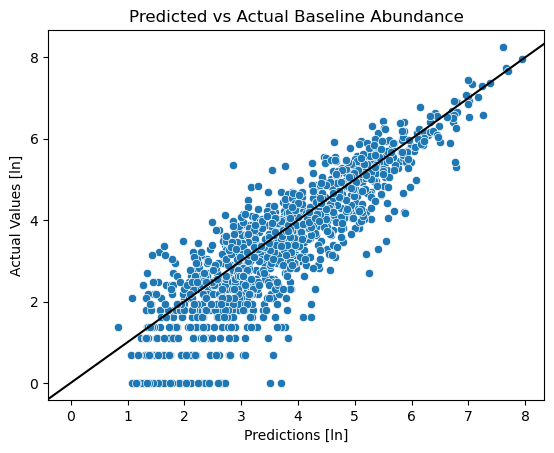

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.clf() # clears previous plot

sns.scatterplot(data=results,
               x='prediction_data',
               y='actual_log')

# plt.axline() used to create x=y line. A perfect trend would stick to this line. 
plt.axline(xy1=(0,0), slope=1, color='black') # xy1=() marks the intercept
plt.xlabel('Predictions [ln]')
plt.ylabel('Actual Values [ln]')
plt.title('Predicted vs Actual Baseline Abundance')

plt.show()

Predicted vs Actual Abundance Observations:

- Model appears to overestimate actual counts below ln(2).
- Distribution appears more balanced across all other regions.

#### Fitted Values vs Residuals
This visual is used to determine if a model underpredicts or overpredicts across its 
'fitted range' (predicted values).

The 'lowess line' reveals the trend of the residuals.

Under predictions are seen when the lowess line tracks above the x=0 line. 

Over predictions occur when the lowess line tracks below the x=0 line.

A model without bias, will track perfectly along this line.

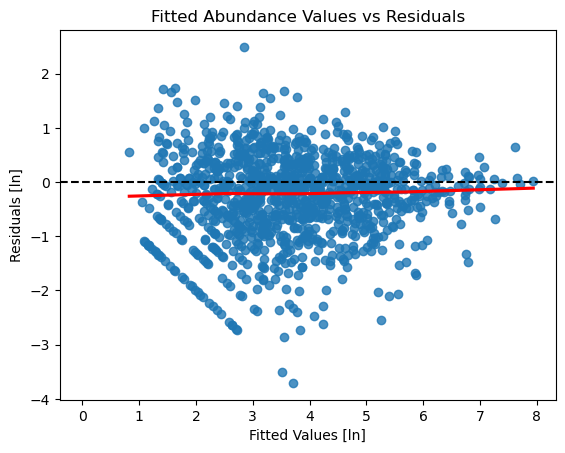

In [10]:
from statsmodels.nonparametric.smoothers_lowess import lowess

plt.clf() # clears previous plot

sns.regplot(data=results,
             x='prediction_data',
             y='resid',
             lowess=True, # default argument is set to false
             line_kws={'color':'red'})

# x=0 line used for visual reference. Points falling on this line are perfect 
# predictions (actual - prediction = 0)
plt.axline(xy1=(0,0), slope=0, color='black', linestyle='--')
plt.xlabel('Fitted Values [ln]')
plt.ylabel('Residuals [ln]')
plt.title('Fitted Abundance Values vs Residuals')

plt.show()

Fitted Values vs Residuals Observations:

- Model tends to overestimate abundance across the fitted range.
- The lowess curve tracks below x=0 line across the predicted range.
- Overestimation bias is greater at lower predicted abundances. Surveys with larger 
sample sizes tend towards the x=0 line.

#### Q-Q Plot

The q-q plot is used to compare the distribution of the model residuals against a
normal distribution with the same sample size. The quantiles of the model residuals
are plotted against the residual quantiles of the normal distribtuion.
A perfectly normal distribution is shown when the model residual quantiles track the 
x=y line. When the model tracks below x=y, this indicates that the residual at this 
quantile is less than would be expected assuming a normal distribution.
Tracking above x=1, indicates the residual at this quantile is greater than would be 
expected.

<Figure size 640x480 with 0 Axes>

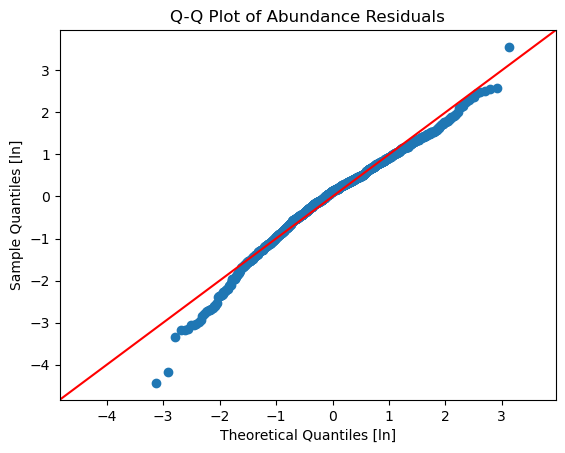

In [11]:
plt.clf() # clears previous plot

from statsmodels.api import qqplot # importing the required package

qqplot(data=results.resid,
       # 'fit=True' transforms x-axis from standard deviation to the same units as the 
       # residuals. Now shows the normal distribution of residuals.
      fit=True, 
       line='45') # x=y reference line shows normal distribution of residuals

plt.ylabel('Sample Quantiles [ln]')
plt.xlabel('Theoretical Quantiles [ln]')
plt.title('Q-Q Plot of Abundance Residuals')

plt.show() # include this line to eliminate duplicate plots

#### Acquiring Baseline Predictions from Prefferred Model: 'lambda=-1.8, spline count=9'

In [12]:
# First, extracting dataframe from dictionary 
prediction_model_b = obs_12_13_14_parameters[-1.8,9]

# Assigning new variable name to 'model_b' predictions
prediction_model_b = (
    prediction_model_b
    # column must be renamed so it is distinguishable from first model
    .rename(columns={'prediction_data':'prediction_model_b'})
)

# Merging second group of predictions into main 'results' dataframe
results = results.merge(prediction_model_b, 
                        # the merging criteria
                        on=['species_code',
                            'site_code', 
                            'consecutive_survey_group'], 
                        how='inner', 
                        suffixes=['','_b'])

#### Computing the Residuals for Model: 'lambda=-1.8, spline count=9'

In [13]:
results['resid_b'] = results['actual_log'] - results['prediction_model_b']

#### Comparative Visualisations, Models: 'lambda=0.6, spline count=4' vs 'lambda=-1.8, spline count=9'

#### Predicted vs Actual Abundance

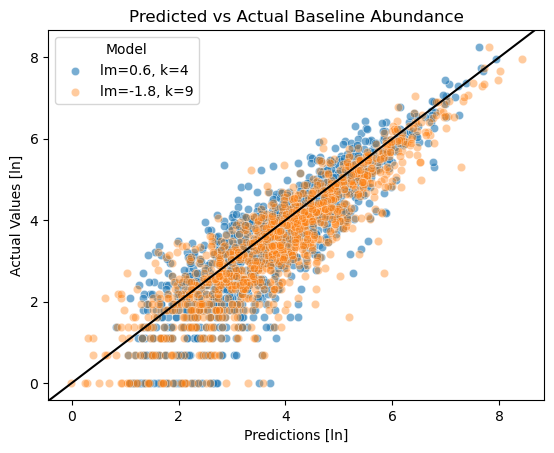

In [14]:
plt.clf() # clears previous plot

# model with parameters lambda=0.6, K=4
sns.scatterplot(data=results,
               x='prediction_data',
               y='actual_log',
                label='lm=0.6, k=4',
               alpha=0.6) # adjusts the transparency of points

# model with parameters lambda=-1.8, K=9
sns.scatterplot(data=results,
                 x='prediction_model_b',
                 y='actual_log',
                label='lm=-1.8, k=9',
               alpha=0.4) # adjusts the transparency of points

# plt.axline() used to create x=y line. A perfect trend would stick to this line. 
plt.axline(xy1=(0,0), slope=1, color='black') # xy1=() marks the intercept
plt.legend(title='Model')
plt.xlabel('Predictions [ln]')
plt.ylabel('Actual Values [ln]')
plt.title('Predicted vs Actual Baseline Abundance')

plt.show()

#### Predicted vs Actual Abundance Observations

- Both models show a good relationship between actual and predicted values. This is
evidenced by the close proximity of the residuals to the x=y line.
- For actual values > 1.5, a larger proportion of the model lm=-1.8, K=9 residuals can 
be found to the right of the x=y line, indicating this model has a greater tendecny to 
overestimate relative to model lm=0.6, k=4. 
- The largest residuals to the left of the x=y line are predominantly from model 
lm=0.6, K=4.

#### Fitted Values vs Residuals

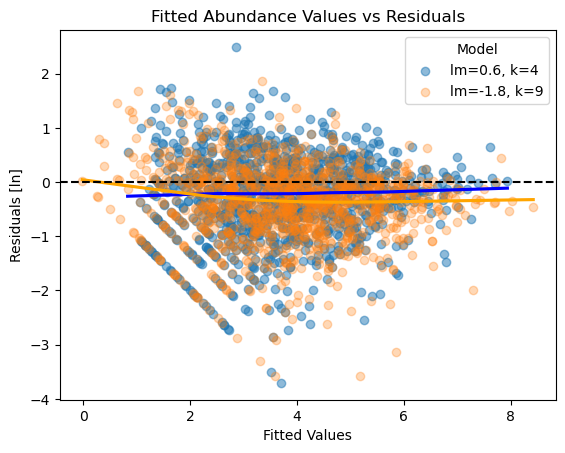

In [15]:
plt.clf() # clears previous plot

# model with parameters lambda=0.6, K=4
sns.regplot(data=results,
             x='prediction_data',
             y='resid',
             lowess=True,
              label='lm=0.6, k=4',
             line_kws={'color':'blue'},
             scatter_kws={'alpha':0.5})

# model with parameters lambda=-1.8, K=9
sns.regplot(data=results,
             x='prediction_model_b',
             y='resid_b',
             lowess=True,
              label='lm=-1.8, k=9',
             line_kws={'color':'orange'},
             scatter_kws={'alpha':0.3})

# x=0 line used for visual reference. Points falling on this line are perfect 
# predictions (actual - prediction = 0)
plt.axline(xy1=(0,0), slope=0, color='black', linestyle='--')
plt.legend(title='Model')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals [ln]')
plt.title('Fitted Abundance Values vs Residuals')

plt.show()

#### Residuals vs Fitted Values Observations

- As shown by the lowess curve, the magnitude and/or frequency of underestimations by 
model lm=-1.8, K=9 tends to be greater for predictions >ln(2).
- In general the lowess curve for model lm=-1.8, K=9 does not track the y=0 line as well 
as model lm=0.6, K=4.

#### Q-Q Plot

<Figure size 640x480 with 0 Axes>

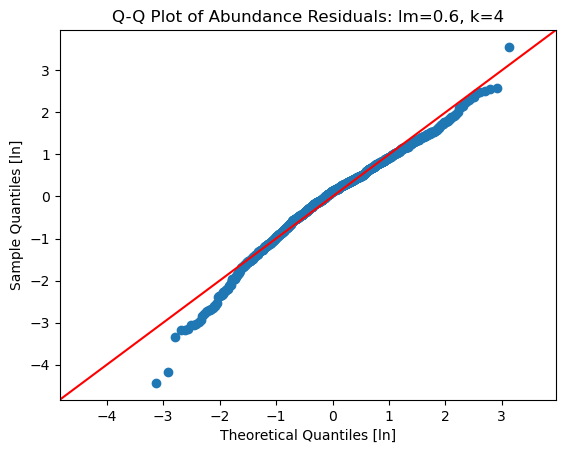

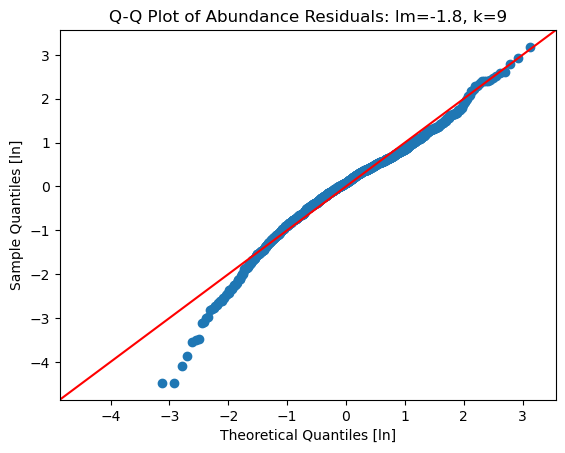

In [16]:
plt.clf() # clears revious plot

from statsmodels.api import qqplot

# model with parameters lambda=0.6, K=4
qqplot(data=results.resid,
       # 'fit=True' transforms x-axis from standard deviation to the same units as the 
       # residuals. Now shows the normal distribution of residuals.
      fit=True,
      line='45')
plt.ylabel('Sample Quantiles [ln]')
plt.xlabel('Theoretical Quantiles [ln]')
plt.title('Q-Q Plot of Abundance Residuals: lm=0.6, k=4')

# model with parameters lambda=-1.8, K=9
qqplot(data=results.resid_b,
      fit=True,
      line='45')
plt.ylabel('Sample Quantiles [ln]')
plt.xlabel('Theoretical Quantiles [ln]')
plt.title('Q-Q Plot of Abundance Residuals: lm=-1.8, k=9')

plt.show() # include this line to eliminate duplicate plots

#### Q-Q Plot Observations

- More negative extremes found in theoretical quntiles below ln(-1.5) in model -1.8, K=9.
- Although residuals track the x=y line more closely in the upper quantiles. 

#### Conclusion
Model with parameters k=4, lambda=0.6 appears to be most optimal for the data.